This notebook attempts to perform basic EDA and evaluate linear regression models on to Kaggle dataset https://www.kaggle.com/c/house-prices-advanced-regression-techniques   
Steps:
1. Load the required Libraries
2. Loading the test and train datasets
3. Examine the target variable 'SalePrice' and apply log transformation to overcome the skewness
4. Exploring the numeric and categorical variables and determine the most important ones by looking at the correlations.
5. Impute the missing values based with help from data dictionary and drop the non-relevant (Utilities, Id ) columns
6. Convert the Categorial variables to Ordinal wherever possible
7. Feature Engineering: Try and combine relevant fields and cut the redundant ones. For example, instead of considering each variable alone, create a new variable total bath, total square foot, etc.
8. Transform the data for chosen variables to overcome skewness
9. Drop the variables with co-linearity, ex: Garage Cars and Garage Area: One of them should suffice.
10. Apply one-hot encoding on the remaining categorical variables
11.  Evaluate the Lasso and Ridge, Elastic Net, LGB models using test_split_train and cross-validation techniques to calculate RMSE.
12. Apply above techniques along with random forest, XGBoost and ensemble techniques and evaluate the best technique
13. Blended models seems to have better performance over single predictors


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_train = train = pd.read_csv("/content/train.csv")
sample,features = train.shape[0],train.shape[1]
print(f"Train data contains {sample} rows and {features} columns")
train.head()

Train data contains 1460 rows and 81 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_test = test = pd.read_csv("/content/test.csv")
sample,features = test.shape[0],test.shape[1]
print(f"Test data contains {sample} rows and {features} columns")
test.head()

Test data contains 1459 rows and 80 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


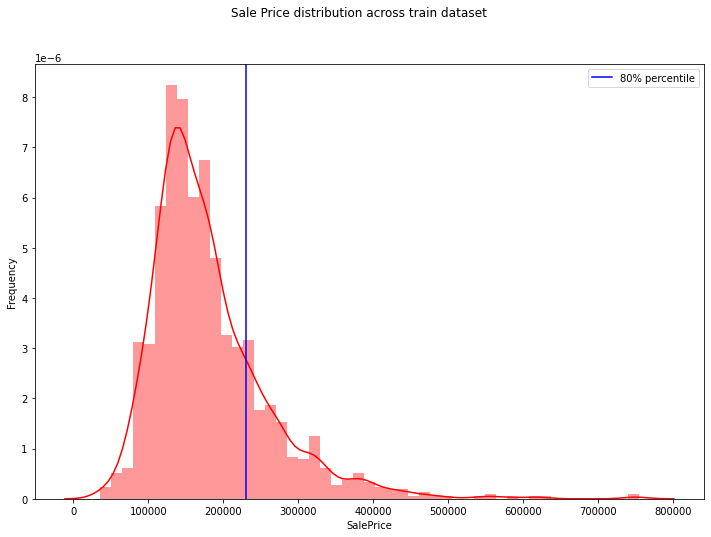

Above Distribution has 1.88 skewness values
Above Distribution has 6.54 kurtosis values


In [4]:
plt.figure(figsize = (12,8))
sns.distplot(train['SalePrice']
                ,color = 'r')
#plt.xlabel("Sale Price distribution across train dataset")
plt.ylabel("Frequency")
skewness = np.round(train['SalePrice'].skew(),2)
kurtosis = np.round(train['SalePrice'].kurt(),2)
plt.axvline(np.percentile(train['SalePrice'],80),color = 'blue',label = "80% percentile")
plt.suptitle(f"Sale Price distribution across train dataset")
plt.legend()
plt.show()

print(f"Above Distribution has {skewness} skewness values")
print(f"Above Distribution has {kurtosis} kurtosis values")

SalePrice features is not normally distributed, and can be clearly interpreted as right skewed as there is long tail in the right of the plot. To check if above features is log normally distributed or not we are going to plot log values of SalePrice feature. If resulted distribution is normally distributed then we can take log(SalePrice) as target variable.

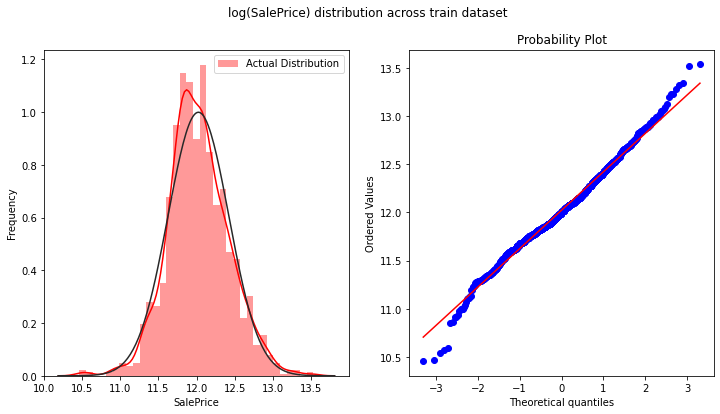

In [5]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
sns.distplot(np.log(train['SalePrice'])
                ,color = 'r',label = "Actual Distribution", fit=norm)
#plt.xlabel("Sale Price distribution across train dataset")
plt.ylabel("Frequency")
plt.suptitle(f"log(SalePrice) distribution across train dataset")
plt.legend()

plt.subplot(1,2,2)
stats.probplot(np.log(train['SalePrice']),plot = plt)

plt.show()

In [6]:
df = pd.concat([train,test])
df.shape

(2919, 81)

Finding the top correlation features



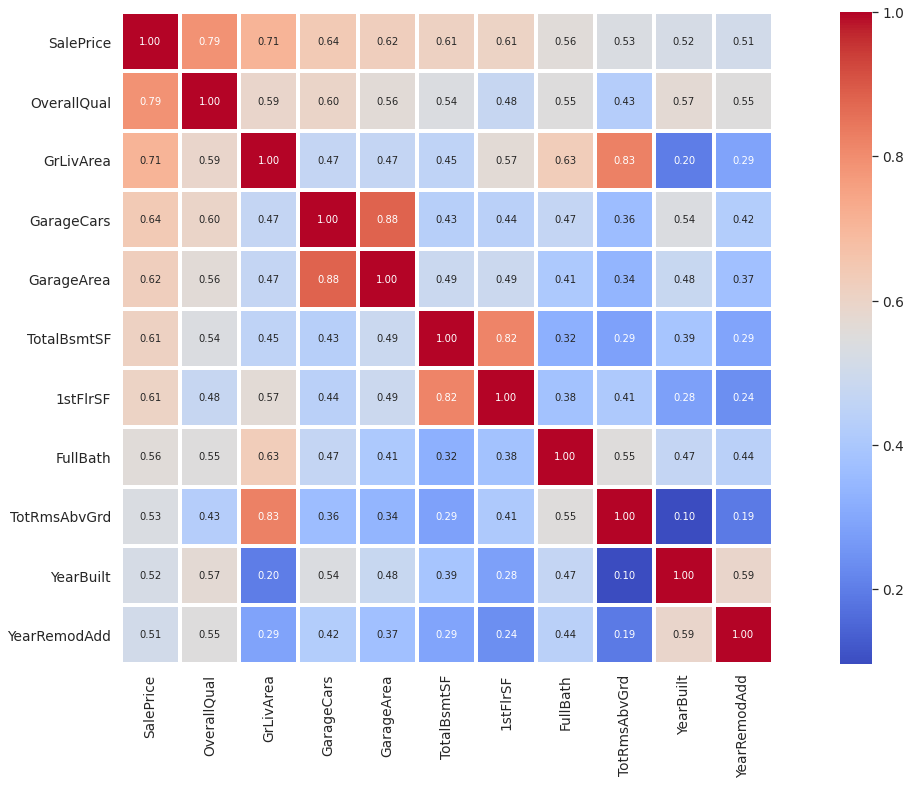

In [7]:
corr = df[df.columns[1:]].corr()['SalePrice'][:]
corr = corr[(corr >= 0.5)].sort_values(ascending=False)
plt.figure(figsize=(24,12))
topcorrcols = corr.index
sns.set(font_scale = 1.25)
sns.heatmap(train[topcorrcols].corr(), annot=True,linewidths=3,cmap='coolwarm',square=True,fmt='.2f',annot_kws={'size': 10})

We can see that multicollinearity between different features. For example: the correlation between GarageCars and GarageArea is very high (0.88), and both have similar (high) correlations with SalePrice.

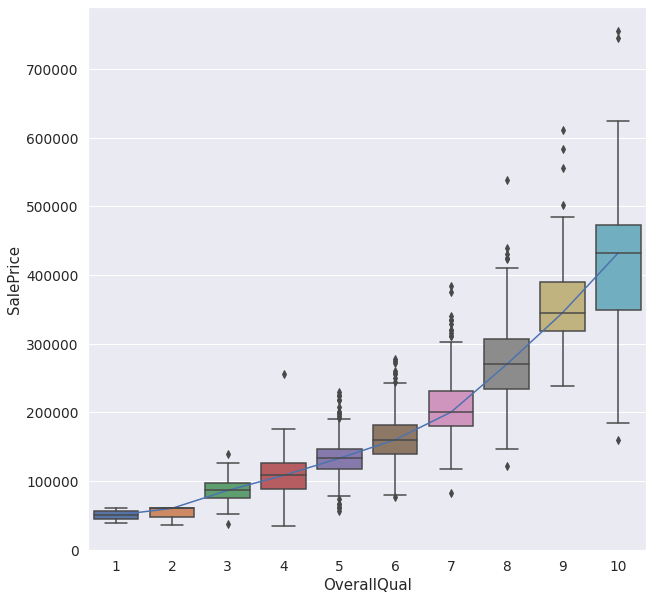

In [8]:
#Analyze the Categorical Variables

#box plot overallqual/saleprice
median =  train.groupby('OverallQual')['SalePrice'].median()
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 10))
ax.plot(median.values)
fig = sns.boxplot(x=var, y="SalePrice", data=data)


As expected, the sale price increases for a better quality house. Next Step is to fill in all the missing values

In [9]:
Quality = {'None': 0, 'Po': 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

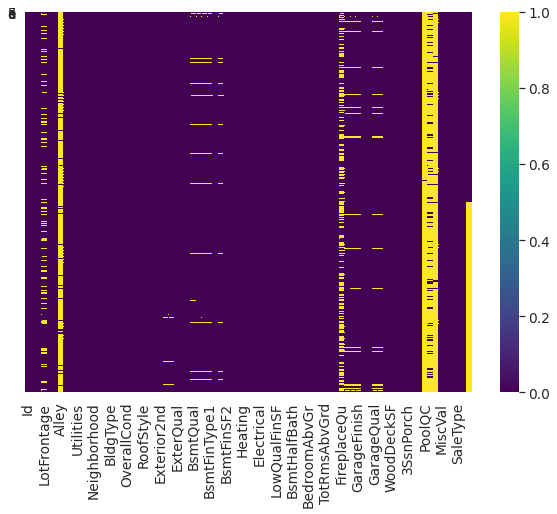

In [10]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(),yticklabels='False',cmap='viridis')

In [11]:
#Convert certain numeric values to categories
def convert_dtype(data):
    data['MSSubClass'] = data['MSSubClass'].astype('str')
    data['MoSold'] = data['MoSold'].astype('str')
    return(data)
df = convert_dtype(df)
print(df.shape)

(2919, 81)


In [12]:
#Fill the missing values with either 0 or None As per the data description

#Pool Variables , Try to fit in the Categorial variables as Ordinal, Nominal Continous etc

df['PoolQC'] = df['PoolQC'].fillna('None')
df['PoolQC'] = df['PoolQC'].map(Quality)

#Check if there is pool area and Pool QC is still 0.
#df_train['PoolQC'].value_counts()
df[(df['PoolArea'] > 0) & (df['PoolQC'] == 0)][['PoolArea','PoolQC','OverallQual']]


#In the test training set we have certain values with PoolQC = , even with pool area. Try to match up this value with 
#OverallQuality
df.at[960,'PoolQC'] = 2
df.at[1043,'PoolQC'] = 3
df.at[1139,'PoolQC'] = 2


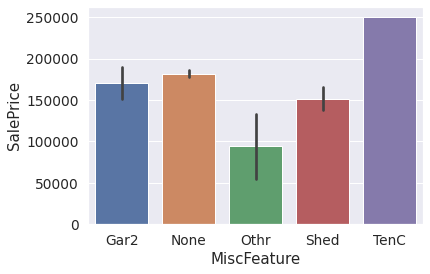

In [13]:
#Miscellaneous Features - Based on the barchart the values do not seem to be Ordinal
df['MiscFeature'].value_counts()
#Replace the NA's with None - Indicating no mis features. 
df['MiscFeature'] = df['MiscFeature'].fillna('None')
df['MiscFeature'] = df['MiscFeature'].astype('category')
sns.barplot(x='MiscFeature',y='SalePrice',data=df[df['SalePrice'] != np.nan])


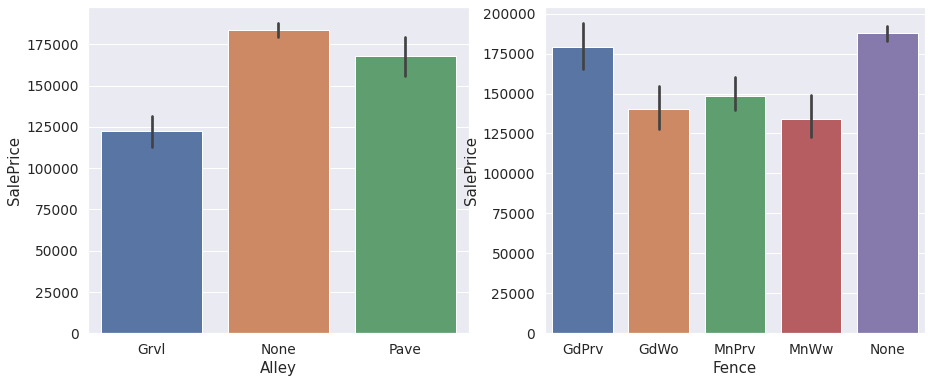

In [14]:
#Alley,Fence

#Replace the NA's with None - Indicating no mis features. 
df['Alley'] = df['Alley'].fillna('None')
df['Alley'] = df['Alley'].astype('category')
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(x='Alley',y='SalePrice',data=df[df['SalePrice'].notnull()])

df['Fence'] = df['Fence'].fillna('None')
df['Fence'] = df['Fence'].astype('category')
plt.subplot(1,2,2)
sns.barplot(x='Fence',y='SalePrice',data=df[df['SalePrice'].notnull()])

In [15]:
#Number of FirePlaces, Fire Place Quality
df[['Fireplaces','FireplaceQu']].isnull().sum()
len(df[df['Fireplaces'] == 0])
#We can replace the values FireplaceQu with None and use the above Quality Matix to convert the data to ordinal
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['FireplaceQu'] = df['FireplaceQu'].map(Quality)


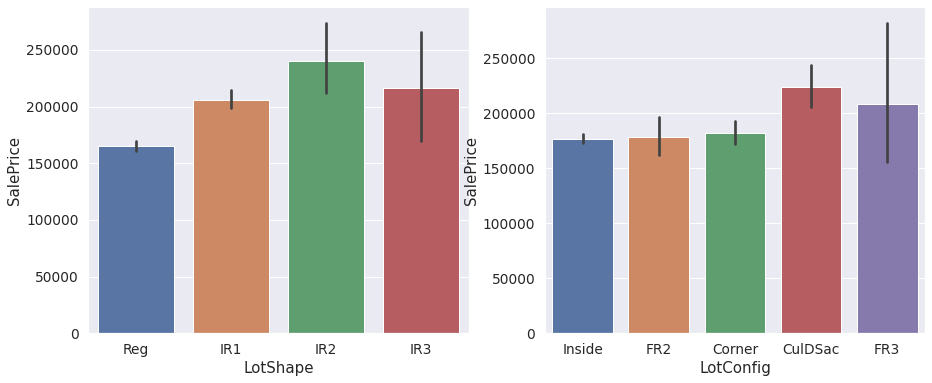

In [16]:
df["LotFrontage"] = df.groupby(by="Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(x='LotShape',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)
plt.subplot(1,2,2)
sns.barplot(x='LotConfig',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)
#Lot Shape - Convert Lot Shape into Ordinal
df['LotShape'] = df['LotShape'].map({'IR3':0,'IR2':1,'IR1':2,'Reg':3})
df['LotConfig'] = df['LotConfig'].astype('category')


In [17]:
#Garage Variables : There are seven garage variables all togerther
GarageCols = ['GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']
df[GarageCols].isnull().sum()

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

#Form the Ordinal and Categorical Variables
#1. GarageType 
df['GarageType'] = df['GarageType'].astype('category')
df['GarageFinish'] = df['GarageFinish'].map({'None':0,'Unf':1,'RFn':2,'Fin':3})
df['GarageQual'] = df['GarageQual'].map(Quality)
df['GarageCond'] = df['GarageCond'].map(Quality)

In [18]:
#Basement Variables : There are 11 Basement Variables
BasementCols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'\
                ,'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df[BasementCols].isnull().sum()

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')

df['BsmtQual'] = df['BsmtQual'].map(Quality)
df['BsmtCond'] = df['BsmtCond'].map(Quality)
df['BsmtExposure'] = df['BsmtExposure'].map({'None':0,'No':1,'Mn':2,'Av':3,'Gd':4})
df['BsmtFinType1'] = df['BsmtFinType1'].map({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df['BsmtFinType2'] = df['BsmtFinType2'].map({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})

In [19]:
#Mansory Variables

MansoryCols = ['MasVnrType', 'MasVnrArea', 'MSZoning' ]
df[MansoryCols].isnull().sum()
pd.crosstab(df['MasVnrType'],df['MSZoning'])

MSZoning,C (all),FV,RH,RL,RM
MasVnrType,,,,,
BrkCmn,0,0,0,24,1
BrkFace,0,32,4,770,73
None,25,80,22,1247,364
Stone,0,20,0,207,22


In [20]:
(df[(df['MasVnrType'].isnull()) & (df['MasVnrArea'].notnull())])[['MasVnrType','MasVnrArea','MSZoning']]
#Replace the above value with BrkFace
df.at[1150,'MasVnrType'] = 'BrkFace'
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df['MSZoning'] = df['MSZoning'].astype('category')
df['MSZoning'].value_counts()
Masonry = {'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2} #Calculated based on the median of the sale prices
df["MasVnrType"] = df['MasVnrType'].map(Masonry)

In [21]:
#Kitchen Variables
#df['KitchenQual'] = df.groupby(by = 'OverallQual')['KitchenQual'].transform(lambda x: x.fillna(x.mode()))
df['KitchenQual'] = df['KitchenQual'].fillna('TA')
df['KitchenQual'] = df['KitchenQual'].map(Quality)

In [22]:
#Utilities
df['Utilities'].value_counts()
#Except for 2 missing values in the test training set all the column has same value 'AllPub'. Imputing the data with same value
#does not provide any additional benefit and will not be of any use for prediction as this would be a constant value.
#We can safely drop this value

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [23]:
#Home Functionality
df['Functional'].isnull().sum()
df['Functional'].value_counts()
#Imputing the missing values with mode
df["Functional"] = df["Functional"].fillna(df['Functional'].mode()[0])
#Based on the description, this can be considered an ordinal parameter
df['Functional'] = df['Functional'].map({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})

In [24]:
#Exterior Variables
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].astype('category')
df['Exterior2nd'] = df['Exterior1st'].astype('category')

df['ExterQual'] = df['ExterQual'].map(Quality)
df['ExterCond'] = df['ExterCond'].map(Quality)

In [25]:
#Electrical System
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['Electrical'] = df['Electrical'].astype('category')

#SaleType
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['SaleType'] = df['SaleType'].astype('category')

#SaleCondition
df['SaleCondition'] = df['SaleCondition'].astype('category')


In [26]:
df['Foundation'] = df['Foundation'].astype('category')
df.Foundation.value_counts()

#Heating
df['Heating'] = df['Heating'].astype('category')
df['HeatingQC'] = df['HeatingQC'].map(Quality)
df['CentralAir'] = df['CentralAir'].map({'N':0,'Y':1})

In [27]:
#Roof, LandContour(Flatness of property), landslope, Building Type,House Style, Neighborhood, condition1, condition2

df['RoofStyle'] = df['RoofStyle'].astype('category')
df['RoofMatl'] = df['RoofMatl'].astype('category')
df['LandContour'] = df['LandContour'].astype('category')
df['LandSlope'] = df['LandSlope'].astype('category')
df['BldgType'] = df['BldgType'].astype('category')
df['HouseStyle'] = df['HouseStyle'].astype('category')
df['Neighborhood'] = df['Neighborhood'].astype('category')
df['Condition1'] = df['Condition1'].astype('category')
df['Condition2'] = df['Condition2'].astype('category')

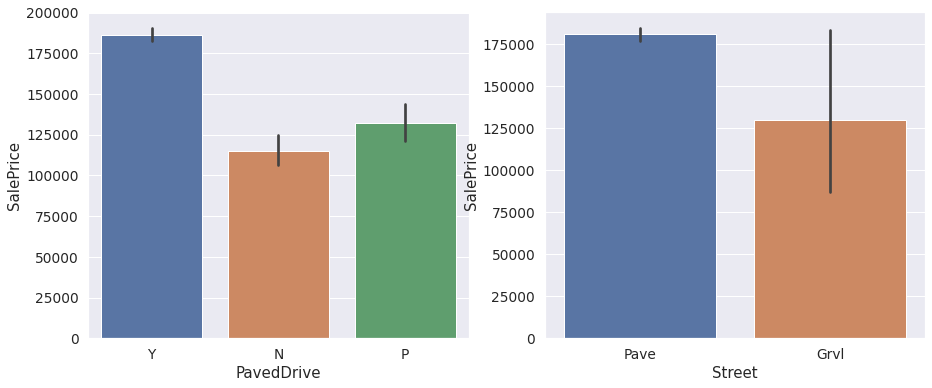

In [28]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(x='PavedDrive',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)
plt.subplot(1,2,2)
sns.barplot(x='Street',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)

df['PavedDrive'] = df['PavedDrive'].map({'N':0,'P':1,'Y':2})
df['Street'] = df['Street'].map({'Grvl':0,'Pave':1})

In [29]:
droplist = ['Id','Utilities']
df.drop(columns=droplist,axis='columns', inplace=True)

In [30]:
val = df.isnull().sum() 
val[val > 0]

SalePrice    1459
dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


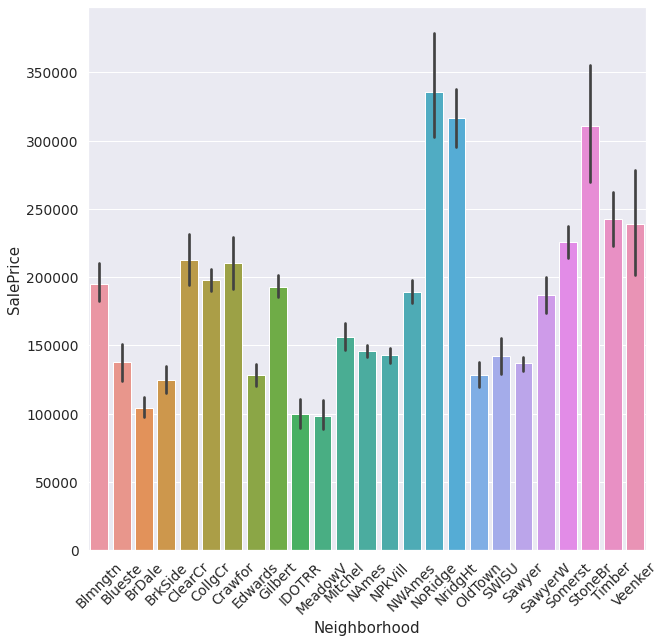

In [31]:
#Neighborhood Binning
df_tmp = df[df['SalePrice'].notnull()]
df_tmp.sort_values(by=['SalePrice'],inplace=True,ascending=False)
df_tmp = df_tmp.reset_index(drop=True)
plt.figure(figsize = (10,10))
g = sns.barplot(x='Neighborhood',y='SalePrice',data=df_tmp,estimator=np.mean)


for item in g.get_xticklabels():
    item.set_rotation(45)

In [32]:
df_sp_median = df_tmp.groupby(by='Neighborhood')[['Neighborhood','SalePrice']].agg(['median','mean'])
df_sp_median.sort_values([('SalePrice','median')]).head(5)

SalePrice               
                median           mean
Neighborhood                         
MeadowV        88000.0   98576.470588
IDOTRR        103000.0  100123.783784
BrDale        106000.0  104493.750000
OldTown       119000.0  128225.300885
Edwards       121750.0  128219.700000

In [33]:
list1  = ['StoneBr', 'NridgHt', 'NoRidge']
list2 = ['MeadowV', 'IDOTRR', 'BrDale']
df['NeighborhoodBin'] = [ 2 if item in list1 else 0 if item in list2  else 1 for item in df['Neighborhood']]


#Remove Neighborhood
droplist = ['Neighborhood']
df.drop(droplist,axis=1,inplace=True)

Skewness/Feature Engineering

Above Distribution has 1.27 skewness values
Above Distribution has 4.12 kurtosis values


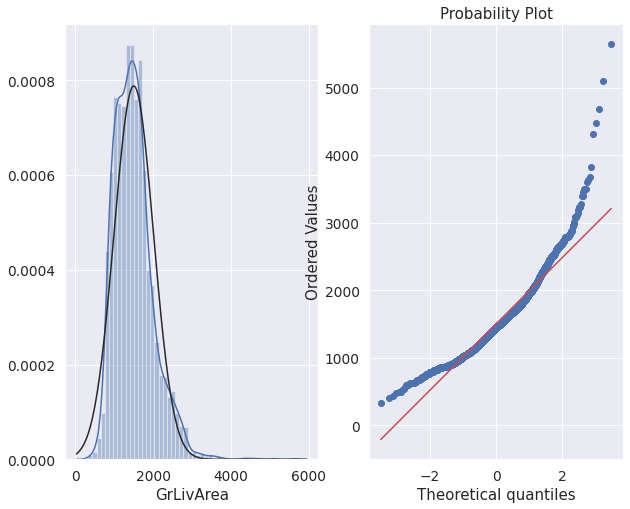

In [34]:
#Check for the factors with high correlation to sales price
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.distplot(df['GrLivArea'], fit=norm);
plt.subplot(1,2,2)
res = stats.probplot(df['GrLivArea'], plot=plt)
skewness = np.round(df['GrLivArea'].skew(),2)
kurtosis = np.round(df['GrLivArea'].kurt(),2)

print(f"Above Distribution has {skewness} skewness values")
print(f"Above Distribution has {kurtosis} kurtosis values")

Above Distribution has 0.01 skewness values
Above Distribution has 0.21 kurtosis values


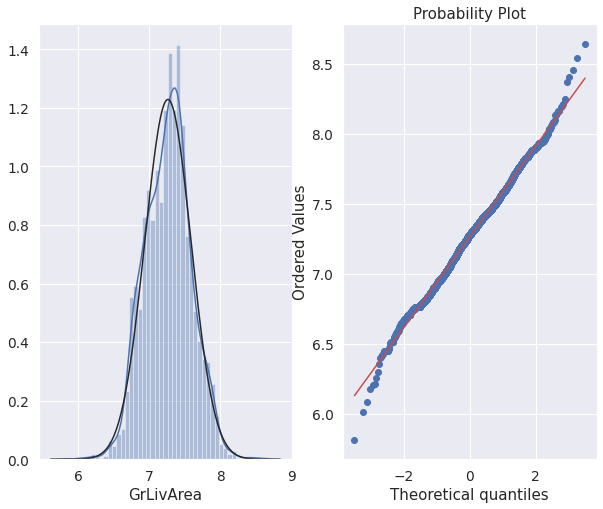

In [35]:
df['GrLivArea'] = np.log1p(df['GrLivArea'])
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.distplot(df['GrLivArea'], fit=norm);
plt.subplot(1,2,2)
res = stats.probplot(df['GrLivArea'], plot=plt)
skewness = np.round(df['GrLivArea'].skew(),2)
kurtosis = np.round(df['GrLivArea'].kurt(),2)

print(f"Above Distribution has {skewness} skewness values")
print(f"Above Distribution has {kurtosis} kurtosis values")

In [36]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
df['HasBsmt'] = 0 
df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1


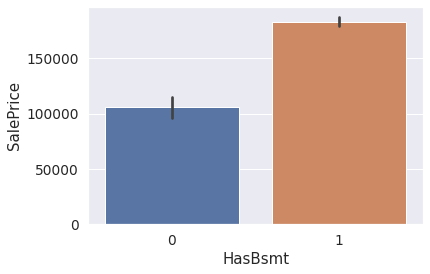

In [37]:
sns.barplot(x='HasBsmt',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)

Above Distribution has 1.51 skewness values
Above Distribution has 9.79 kurtosis values


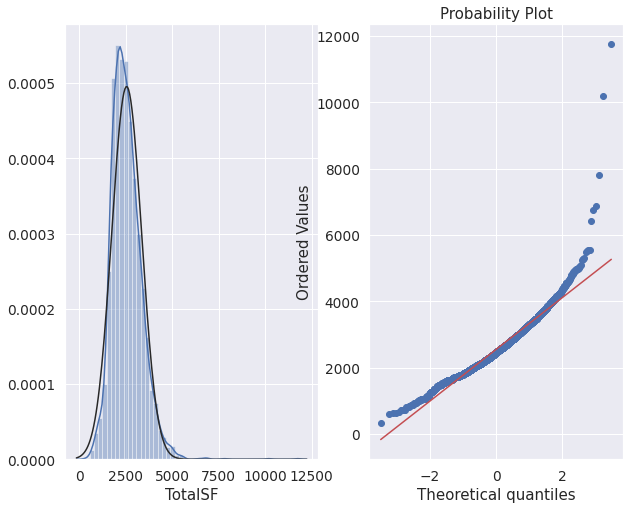

In [38]:
#create column for new variable : Total Square Feet
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.distplot(df['TotalSF'], fit=norm);
plt.subplot(1,2,2)
res = stats.probplot(df['TotalSF'], plot=plt)
skewness = np.round(df['TotalSF'].skew(),2)
kurtosis = np.round(df['TotalSF'].kurt(),2)

print(f"Above Distribution has {skewness} skewness values")
print(f"Above Distribution has {kurtosis} kurtosis values")
droplist = ['TotalBsmtSF','1stFlrSF','2ndFlrSF']
df.drop(droplist,axis=1,inplace=True)

Above Distribution has -0.37 skewness values
Above Distribution has 1.66 kurtosis values


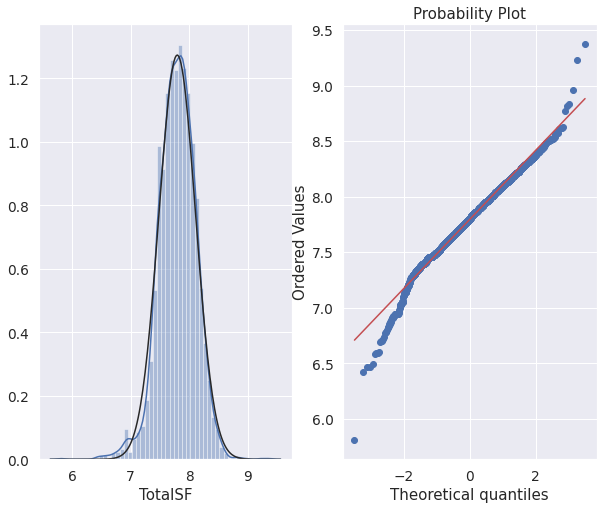

In [39]:
df['TotalSF'] = np.log1p(df['TotalSF'])
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.distplot(df['TotalSF'], fit=norm);
plt.subplot(1,2,2)
res = stats.probplot(df['TotalSF'], plot=plt)
skewness = np.round(df['TotalSF'].skew(),2)
kurtosis = np.round(df['TotalSF'].kurt(),2)

print(f"Above Distribution has {skewness} skewness values")
print(f"Above Distribution has {kurtosis} kurtosis values")

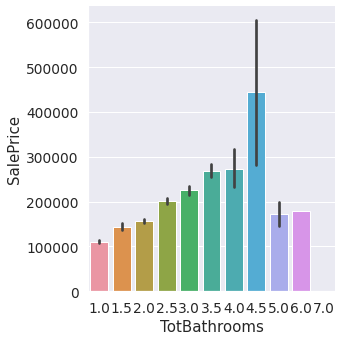

In [40]:
df['TotBathrooms'] = df['FullBath'] + (df['HalfBath']*0.5) + df['BsmtFullBath'] + df['BsmtHalfBath']
g = sns.catplot(x='TotBathrooms', y='SalePrice', data=df,kind='bar')

droplist = ['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']
df.drop(droplist,axis=1,inplace=True)





In [41]:
#Dropping Highly Corelated Variables

droplist = ['YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'TotRmsAbvGrd', 'BsmtFinSF1']
df.drop(droplist,axis=1,inplace=True)

In [42]:
df.shape

(2919, 69)

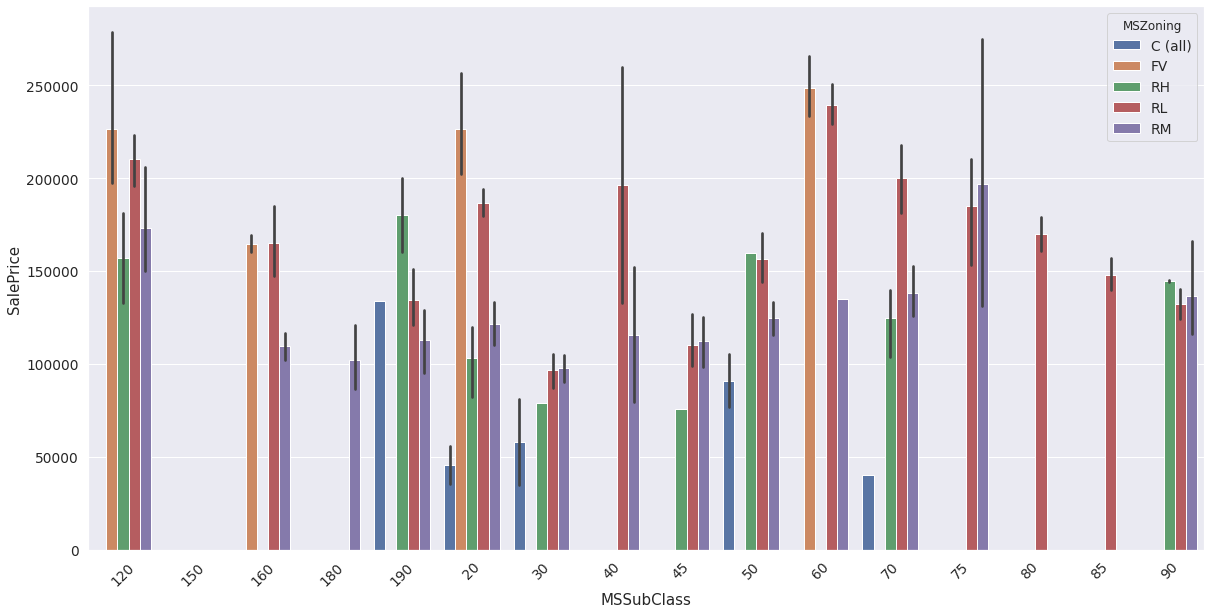

In [43]:
df['MSSubClass'].astype('category')
df_tmp = df[df['MSSubClass'].notnull()]
df_tmp.sort_values(by=['MSSubClass'],inplace=True,ascending=False)
df_tmp = df_tmp.reset_index(drop=True)
plt.figure(figsize = (20,10))
g = sns.barplot(x='MSSubClass',y='SalePrice',data=df_tmp,estimator=np.mean,hue='MSZoning')


for item in g.get_xticklabels():
    item.set_rotation(45)

In [44]:
df_sp_median = df_tmp.groupby(by='MSSubClass')[['MSSubClass','SalePrice']].agg(['median','mean'])
df_sp_median.sort_values([('SalePrice','median')])

SalePrice               
              median           mean
MSSubClass                         
180          88500.0  102300.000000
30           99900.0   95829.724638
45          107500.0  108591.666667
190         128250.0  129613.333333
50          132000.0  143302.972222
90          135980.0  133541.076923
85          140750.0  147810.000000
40          142500.0  156125.000000
160         146000.0  138647.380952
70          156000.0  166772.416667
20          159250.0  185224.811567
75          163500.0  192437.500000
80          166500.0  169736.551724
120         192000.0  200779.080460
60          215200.0  239948.501672
150              NaN            NaN

In [45]:
catvar = df.select_dtypes(include=['category']).columns.tolist()
def cat_onehotencoder(df_concat):
    df_temp = df_concat
    for col in df_temp:
        if df_temp[col].dtype.name == 'category':
            df1 = pd.get_dummies(df_concat[col], drop_first = True)
            df_concat.drop([col], axis = 1, inplace = True)
            
            df_concat = pd.concat([df_concat,df1], axis = 1)
    return df_concat



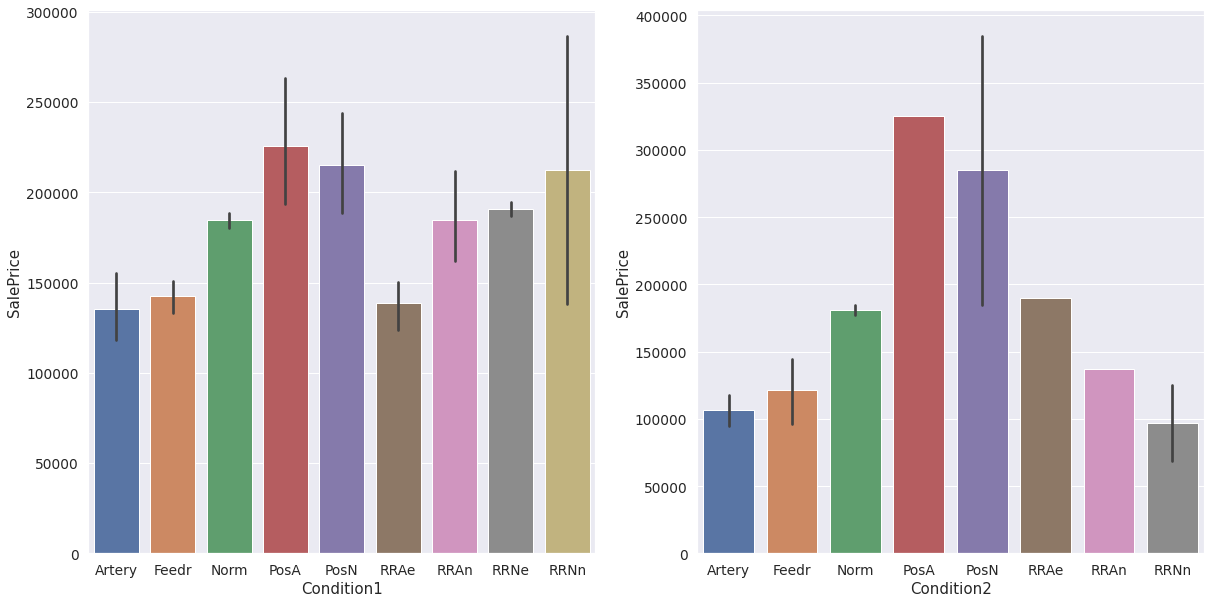

In [46]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.barplot(x='Condition1',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)
plt.subplot(1,2,2)
sns.barplot(x='Condition2',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)

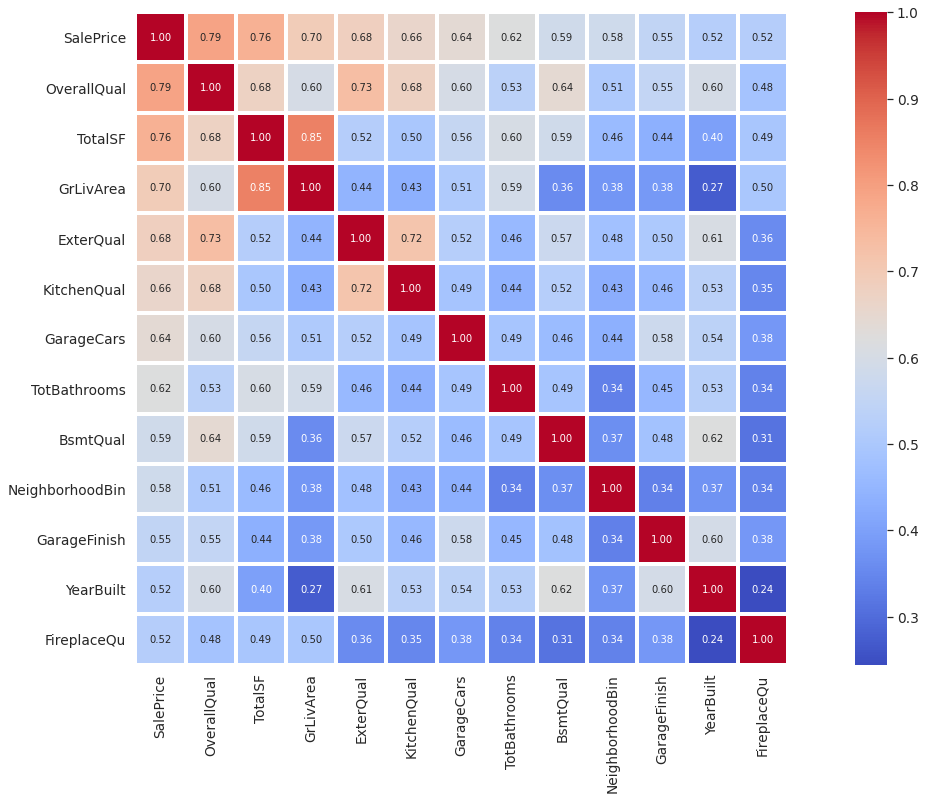

In [47]:
"Outlier Detection"
"Create multiple blox plots to check which has the most variation inrespect to sale price "

df1 = df[df["SalePrice"].notnull()]
corr = df1[df1.columns[1:]].corr()['SalePrice'][:]
corr = corr[(corr >= 0.5)].sort_values(ascending=False)
plt.figure(figsize=(24,12))
topcorrcols = corr.index
sns.set(font_scale = 1.25)
sns.heatmap(df[topcorrcols].corr(), annot=True,linewidths=3,cmap='coolwarm',square=True,fmt='.2f',annot_kws={'size': 10})


In [48]:

df1 = df[df['SalePrice'].notnull()]
outlier_features = ["TotalSF","GrLivArea"]
outliers=[]
def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers


lr_totalsf_outlier = detect_outlier(df1['TotalSF'])
lr_grarea_outlier = detect_outlier(df1['GrLivArea'])


outlierdata = df.loc[df['GrLivArea'].isin(lr_grarea_outlier)]

In [49]:

len(outlierdata)

41

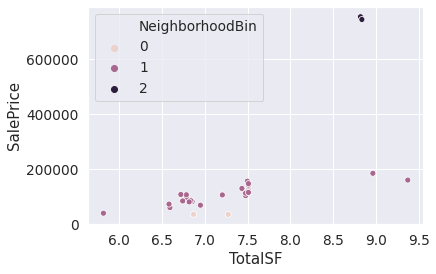

In [50]:
sns.scatterplot(x='TotalSF',y='SalePrice',data=outlierdata,hue='NeighborhoodBin')

In [51]:
df = cat_onehotencoder(df)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 170 entries, MSSubClass to Partial
dtypes: float64(9), int64(37), object(2), uint8(122)
memory usage: 1.5+ MB


Seperate Out Test and Train Data



In [53]:
#Create the log variable for SalePrice

df['SalePrice'] = np.log1p(df['SalePrice'])
df['MoSold'] = pd.to_numeric(df['MoSold'], errors='coerce')
df['MSSubClass'] = pd.to_numeric(df['MSSubClass'], errors='coerce')
df['YrSold'] = pd.to_numeric(df['YrSold'], errors='coerce')

#Split Back the Test and Training DataSets
X_train = df[df['SalePrice'].notnull()]
X_test = df[df['SalePrice'].isnull()]




print('Length before removing the outliers, ', len(X_train))
X_train = X_train.loc[~X_train['GrLivArea'].isin(lr_grarea_outlier)]
y_train = X_train.SalePrice.values
droplist = ['SalePrice']
X_test.drop(droplist,axis=1,inplace=True)
X_train = X_train.drop(droplist,axis=1)
#X_train = X_train.values
print('Length after removing the outliers, ', len(X_train))

print("All  ", df.shape)
print('Train: ',X_train.shape)
print('Test:' ,X_test.shape)

Length before removing the outliers,  1460
Length after removing the outliers,  1431
All   (2919, 170)
Train:  (1431, 169)
Test: (1459, 169)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Evalute a Model using 
1. stochastic gradient descent
2. Elastic Net

In [54]:
#Import required libraries
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeCV,ElasticNetCV,LassoCV,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score,ShuffleSplit
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
import xgboost as XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor, RandomForestRegressor, ExtraTreesRegressor


In [55]:
# Cross Validation : Ridge 


X_train_c,X_test_c,y_train_c,y_test_c=train_test_split(X_train,y_train,test_size=0.002,random_state=52)
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas=[1e-9,1e-8,1e-7,1e-6]

ridgecv_reg= make_pipeline(RidgeCV(alphas=alphas, cv=kfolds))
ridgecv_reg.fit(X_train_c, y_train_c)
y_pred=ridgecv_reg.predict(X_test_c)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.58245e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.72353e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.27404e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.23795e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.4488e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlg

In [56]:
print('-'*10+'RidgeCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test_c,y_pred))
print('Mean Absolute: ',mean_absolute_error(y_test_c,y_pred))
print('Mean Squared Error: ',mean_squared_error(y_test_c,y_pred))

----------RidgeCV----------
R square Accuracy:  0.6426448185582248
Mean Absolute:  0.10625699140136706
Mean Squared Error:  0.017985678166148735


In [57]:
#Elastic Net
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]
l1ratio=[0.87, 0.9,0.92, 0.95,0.97, 0.99, 1]

elasticv_reg= make_pipeline(ElasticNetCV(alphas=alphas, cv=kfolds, l1_ratio=l1ratio))
elasticv_reg.fit(X_train_c, y_train_c)
y_pred_cv=elasticv_reg.predict(X_test_c)
print('-'*10+'ElasticNetCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test_c,y_pred_cv))
print('Mean Absolute Error: ',mean_absolute_error(y_test_c,y_pred_cv))
print('Mean Squared Error: ',mean_squared_error(y_test_c,y_pred_cv))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2827358446883075, tolerance: 0.018720744446788905
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13223597697550638, tolerance: 0.018720744446788905
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028112869598031054, tolerance: 0.018720744446788905
  tol, rng, random, positive)


----------ElasticNetCV----------
R square Accuracy:  0.9021694292570499
Mean Absolute Error:  0.05815315476496193
Mean Squared Error:  0.004923810403683862


In [58]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

lassocv_reg= make_pipeline(LassoCV(alphas=alphas, cv=kfolds))
lassocv_reg.fit(X_train_c, y_train_c)
y_pred_lasso=lassocv_reg.predict(X_test_c)
print('-'*10+'LassoCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test_c,y_pred_lasso))
print('Mean Absolute Error : ',mean_absolute_error(y_test_c,y_pred_lasso))
print('Mean Squared Error: ',mean_squared_error(y_test_c,y_pred_lasso))

----------LassoCV----------
R square Accuracy:  0.9021694292570499
Mean Absolute Error :  0.05815315476496193
Mean Squared Error:  0.004923810403683862


In [59]:
lgb_regressor=lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, 
                                n_estimators=2177, max_bin=50, bagging_fraction=0.65,bagging_freq=5,
                                bagging_seed=7, 
                                feature_fraction=0.201, feature_fraction_seed=7,n_jobs=-1)
lgb_regressor.fit(X_train_c, y_train_c)
y_pred_lgb=lgb_regressor.predict(X_test_c)
print('-'*10+'LGBM'+'-'*10)
print('R square Accuracy: ',r2_score(y_test_c,y_pred_lgb))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test_c,y_pred_lgb))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test_c,y_pred_lgb))

----------LGBM----------
R square Accuracy:  0.9779711459036017
Mean Absolute Error Accuracy:  0.029519673463176705
Mean Squared Error Accuracy:  0.0011087117263792149


In [60]:
from sklearn.feature_selection import RFE, RFECV
rfe = RFE(estimator=lgb_regressor,step=1)
rfe = rfe.fit(X_train_c,y_train_c)



In [61]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train_c.columns), 'Ranking':rfe.ranking_ })
drop_features  = selected_rfe_features[selected_rfe_features['Ranking'] >= 30]['Feature']
droplist = drop_features.values

In [62]:
# Create a new random forest classifier for the most important features
rfr = RandomForestRegressor(n_estimators=200, random_state=1, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
rfr.fit(X_train_c, y_train_c)
# Model evaluation for training set
y_pred_rf =  rfr.predict(X_test_c)

rmse = (np.sqrt(mean_squared_error(y_test_c, y_pred_rf))) #root mean square error
r2 = r2_score(y_test_c, y_pred_rf) # it gives the score based on the relationship between actual output and predicted output by the model

print(rmse,r2)


0.09682533376110368 0.8137264158877808


Build the Model - Take the average of 3 techniques








In [63]:
X_train.drop(droplist,axis=1,inplace=True)
X_test.drop(droplist,axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [64]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]
l1ratio=[0.87, 0.9,0.92, 0.95,0.97, 0.99, 1]

elasticv_reg= make_pipeline(ElasticNetCV(alphas=alphas, cv=kfolds, l1_ratio=l1ratio))
elasticv_reg.fit(X_train, y_train)
y_pred_elastic=elasticv_reg.predict(X_test)
print("Elastic", len(y_pred_elastic))
y_pred_elastic

Elastic 1459


array([11.62633533, 11.99784757, 12.07172403, ..., 12.04477564,
       11.67994557, 12.33440791])

In [65]:
lgb_regressor=lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, 
                                n_estimators=2177, max_bin=50, bagging_fraction=0.65,bagging_freq=5,
                                bagging_seed=7, 
                                feature_fraction=0.201, feature_fraction_seed=7,n_jobs=-1)
lgb_regressor.fit(X_train, y_train)
y_pred_lgb_a=lgb_regressor.predict(X_test)

In [66]:
"Model Using Ridge"
ridge = Ridge()
param_dist = {'alpha':[1e-5,9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5,10,12,15,20,30,50],
              'solver':['auto','svd','lsqr','cholesky','saga']}

clf = GridSearchCV(ridge,
                   param_grid=param_dist,
                   cv=5,
                   return_train_score=True,
                   scoring = 'neg_mean_squared_error')

clf.fit(X_train,y_train)
ridge = clf.best_estimator_ 
ridge.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)

print("Ridge", len(y_pred_ridge))
y_pred_ridge


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.51298e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.51298e-17): result may not be accurate.
  overwrite_a=True).T


Ridge 1459


array([11.62518839, 12.00315989, 12.06765635, ..., 12.03144234,
       11.6768799 , 12.32848237])

In [67]:
regr = Lasso(alpha=0.0005, max_iter=50000)
regr.fit(X_train, y_train)

y_pred_lasso = regr.predict(X_test)
y_pred_lasso

array([11.63126353, 11.98614898, 12.07276367, ..., 12.04799763,
       11.67277881, 12.3320171 ])

In [68]:
final_price =  np.expm1(( y_pred_lasso + (2*y_pred_lgb_a)   + y_pred_elastic  ) / 4)
pred_df = pd.DataFrame(final_price, index=df_test["Id"], columns=["SalePrice"])
pred_df.to_csv('Submission_6.csv', header=True, index_label='Id')

In [69]:
output_all = pd.DataFrame(
    {'Mean': final_price,
     'Lasso': np.expm1(y_pred_lasso),
     'Reg': np.expm1(y_pred_ridge),
     'Elastic': np.expm1(y_pred_elastic),
     'Lgb' : np.expm1(y_pred_lgb_a)
                 
    })
output_all.head()

,Mean,Lasso,Reg,Elastic,Lgb
0,115692.162295,112561.458273,111879.698366,112008.092972,119203.310276
1,162071.291308,160515.012186,163268.891987,162403.850273,162688.253158
2,180003.713250,175037.926996,174146.226976,174856.044227,185206.626464
3,195150.936675,198986.266114,197161.945488,197915.080185,191906.765170
4,192164.326193,198486.867142,199528.177509,199914.202684,185377.840568


In [70]:
import xgboost



In [71]:
xgboost = xgboost.XGBRegressor(learning_rate=0.05,
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      n_estimators=1000,
                      max_depth=5,
                      gamma=5)

xgboost.fit(X_train.values, y_train)

[23:24:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=5,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [72]:
y_pred = xgboost.predict(X_test.values)

final_price =  np.expm1((y_pred))
pred_df = pd.DataFrame(final_price, index=df_test["Id"], columns=["SalePrice"])
pred_df.to_csv('Submission_xgb.csv', header=True, index_label='Id')

In [73]:
final_price

array([121193.8 , 153016.53, 166106.03, ..., 143902.31, 122796.77,
       206117.4 ], dtype=float32)

In [74]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestRegressor(n_estimators=200, random_state=1, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important = clf_important.fit(X_train, y_train)
# Model evaluation for training set
y_pred = clf_important.predict(X_test)
final_price =  np.expm1((y_pred))

final_price =  np.expm1((y_pred))
pred_df = pd.DataFrame(final_price, index=df_test["Id"], columns=["SalePrice"])
pred_df.to_csv('Submission_rfr.csv', header=True, index_label='Id')




In [75]:
import xgboost as xgb
#Machine Learning Algorithm (MLA) Selection and Initialization
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

# First I will use ShuffleSplit as a way of randomising the cross validation samples.
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#create table to compare MLA metrics
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

#index through models and save performance to table
row_index = 0
for alg in models:

    #set name and parameters
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train_c.values, y_train_c)
    
   
    training_results = np.sqrt((-cross_val_score(alg, X_train_c, y_train_c, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt(((y_test_c-alg.predict(X_test_c.values))**2).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_results)*100
    before_model_compare.loc[row_index, 'Test Accuracy'] = (test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=4.020e-04, with an active set of 30 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 37 iterations, i.e. alpha=2.610e-04, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 47 iterations, i.e. alpha=1.847e-04, with an active set of 47 regressors, and the smallest cholesky pivot el

6 LassoLarsIC trained...
7 RandomForestRegressor trained...
[23:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor trained...


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: feature_names must be unique

  FitFailedWarning)


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...",11.805,10.655
1,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",24.566,20.564
2,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",25.136,23.524
3,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",11.824,4.862
4,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_in...",11.674,7.311
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 2....",12.145,9.899
6,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",12.957,9.028
7,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",NaN,2.134


In [76]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train_c.values, y_train_c)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((y_test_c-gs_alg.predict(X_test_c.values))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
after_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 97 iterations, alpha=7.503e-05, previous alpha=7.439e-05, with an active set of 96 regressors.
  ConvergenceWarning)


6 LassoLarsIC trained...
7 RandomForestRegressor trained...
[23:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 0.1, 'coef0': 100, 'degree': 1, 'gam...",11.706,5.874
1,ElasticNet,"{'alpha': 0.001, 'copy_X': True, 'fit_intercep...",11.493,6.913
2,Lasso,"{'alpha': 0.0005, 'copy_X': True, 'fit_interce...",11.504,7.021
3,GradientBoostingRegressor,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",11.515,7.486
4,BayesianRidge,"{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X':...",11.674,7.311
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 1e...",12.346,9.673
6,RandomForestRegressor,"{'max_depth': None, 'max_features': 'auto', 'm...",12.870,9.664
7,XGBRegressor,"{'booster': 'gbtree', 'colsample_bylevel': 0.2...",11.290,6.685


In [77]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
final_predictions = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train.values, y_train)
    gs_best = gs_alg.best_estimator_
    final_predictions.insert(loc = row_index, column = names[0], value = np.expm1(gs_best.predict(X_test.values)))
    print(row_index+1, alg.__class__.__name__, 'final results predicted added to table...')
    names.pop(0)
    
    row_index+=1

print("-"*50)
print("Done")
    
final_predictions.head()

1 KernelRidge final results predicted added to table...
2 ElasticNet final results predicted added to table...
3 Lasso final results predicted added to table...
4 GradientBoostingRegressor final results predicted added to table...
5 BayesianRidge final results predicted added to table...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=2.668e-04, previous alpha=2.651e-04, with an active set of 37 regressors.
  ConvergenceWarning)


6 LassoLarsIC final results predicted added to table...
7 RandomForestRegressor final results predicted added to table...
[23:25:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor final results predicted added to table...
--------------------------------------------------
Done


,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,113401.235655,113613.594064,112558.232036,124479.560554,111858.600800,113928.518163,122740.778996,116364.085938
1,163441.954326,159649.124064,160480.237113,174902.992563,163308.461896,158133.234240,158341.325804,156367.468750
2,174608.145280,175018.809252,175063.399486,188041.650192,174170.434596,171249.157320,177500.542195,184262.953125
3,199201.121063,199237.537007,198979.349216,197084.276521,197162.312513,195921.616258,185013.799262,187299.500000
4,200025.232914,197642.459308,198478.283606,193913.846753,199548.677144,203526.062216,193830.860142,187600.718750


In [80]:
ensemble = final_predictions['Lasso']*(1/10)  + final_predictions['Gradient Boosting']*(2/10) + final_predictions['Bayesian Ridge']*(1.5/10) + final_predictions['Lasso']*(1.5/10) + final_predictions['KernelRidge']*(1/10) + final_predictions['Lasso Lars IC']*(1.5/10) + final_predictions['Random Forest']*(1.5/10)
pred_df = pd.DataFrame(ensemble.values, index=df_test["Id"], columns=["SalePrice"])
pred_df.to_csv('Submission_ensemble.csv', header=True, index_label='Id')

In [81]:
pred_df

,SalePrice
Id,
1461,116654.778379
1462,163412.306515
1463,177273.014555
1464,195796.463920
1465,197940.703469
...,...
2915,89314.959936
2916,86132.143600
2917,165878.173445
